In [8]:
import networkx as nx
import pandas as pd
todos_pontos_linha = pd.read_csv("2022_03_08_pontosLinha.csv")

tipo_linhas_cabral = None
tipo_linhas_portao = None
tipo_linhas_pinheirinho = None
tipo_linhas_boqueirao = None
tipo_linhas_campina_do_siqueira = None
tipo_linhas_capao_da_imbuia = None
todos_tipos = None

def get_pontos_linha(codigo_linha: str, id_itineratio: int) -> pd.core.frame.DataFrame:
    return todos_pontos_linha.query("COD == @codigo_linha and ITINERARY_ID == @id_itineratio").sort_values("SEQ")

def add_pontos_no_grafo(grafo: nx.classes.graph.Graph, pontos_linha: pd.core.frame.DataFrame) -> None:
    for row in pontos_linha.itertuples(index=False):
        NOME = getattr(row, 'NOME')
        NUM = getattr(row, 'NUM')
        SEQ = getattr(row, 'SEQ')
        SENTIDO = getattr(row, 'SENTIDO')
        ITINERARY_ID = getattr(row, 'ITINERARY_ID')
        COD = getattr(row, 'COD')
        #Esse linha garante que os terminais não são duplicados.
        #Para isso a informação referente a linha, que consta no nome do ponto, é removida.
        ID = get_id_ponto(NOME, COD, NUM)
        NOME = ID if 'Terminal' in NOME else NOME
        if 'Terminal' in NOME:
            NOME = ID
            #Codigo arbitrário para facilitar a identificação de terminais.
            COD = str(999)

        grafo.add_node(ID, nome=NOME, num=NUM, seq=SEQ, sentido=SENTIDO, itinerario_id=ITINERARY_ID, cod=COD)            

def add_arestas_entre_pontos(grafo: nx.classes.graph.Graph, pontos_linha: pd.core.frame.DataFrame) -> None:
    #Os indices das linhas do dataframe não são sequenciais, visto que, o dataframe é resultado
    #de uma query.
    indexes = pontos_linha.index.values.tolist()
    capacidade_linha = get_capacidade_por_codigo_linha(pontos_linha.loc[indexes[0], 'COD'])
    for i in range(len(pontos_linha)-1):
        source = get_id_ponto(ponto_info=pontos_linha.loc[indexes[i]])
        target = get_id_ponto(ponto_info=pontos_linha.loc[indexes[i+1]])
        grafo.add_edge(source, target, capacidade=capacidade_linha)

def get_linhas_por_terminal(nome_terminal: str) -> pd.core.frame.DataFrame:
    nome_terminal = f"{nome_terminal} -"
    codigos_linha = todos_pontos_linha.query("NOME.str.contains(@nome_terminal)", engine="python").groupby("COD")
    return list(codigos_linha.groups.keys())

def get_itinerarios_por_linha(codigo_linha: str) -> list:
    return list(todos_pontos_linha.query("COD == @codigo_linha").sort_values("ITINERARY_ID").groupby("ITINERARY_ID").groups.keys())

def get_id_ponto(nome_ponto: str = None, codigo_ponto: str = None, numero_ponto: int = 0, ponto_info: pd.core.series.Series = None) -> str:
    if ponto_info is not None:
        nome_ponto = ponto_info['NOME']
        codigo_ponto = ponto_info['COD']
        numero_ponto = ponto_info['NUM']

    ID = None
    if 'Terminal' in nome_ponto:
        ID = nome_ponto.split(' - ')[0]
    else:
        ID = f"{codigo_ponto}-{str(numero_ponto)}"
        
    return ID

def get_capacidade_por_tipo_linha(tipo_linha: str) -> int:
    tipo_linha = tipo_linha.upper() if tipo_linha is not None else None
    # Capacidade de acordo com a categoria do veículo.
    # Fonte: https://www.urbs.curitiba.pr.gov.br/transporte/rede-integrada-de-transporte/42
    # Cada linha pode apresentar diferentes modelos de veículos utilizados. Comentários foram adicionados indicando o modelo escolhido.
    capacidade = {
        'LIGEIRÃO': 250,
        'EXPRESSO': 250,#Biarticulado
        'LINHA DIRETA': 110,#Padron
        'INTERBAIRROS': 140,#Articulado
        'ALIMENTADOR': 85,#Comum
        'TRONCAL': 85,#Comum
        'CONVENCIONAL': 85#Comum
    }
    
    return capacidade[tipo_linha]

def get_capacidade_por_codigo_linha(codigo_linha: str) -> str:
    tipo = todos_tipos[codigo_linha]
    return get_capacidade_por_tipo_linha(tipo)

def set_tipo_linhas() -> None:
    # Para quase todos os dados abaixo a fonte foi https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/Linhas_x_Empresas_Operadoras_codigo.pdf
    # As exceções estão sinalizadas com comentários

    global tipo_linhas_cabral, tipo_linhas_portao, tipo_linhas_pinheirinho, tipo_linhas_boqueirao, tipo_linhas_campina_do_siqueira, tipo_linhas_capao_da_imbuia
    global todos_tipos

    tipo_linhas_cabral = {
        '020':'INTERBAIRROS',
        '021':'INTERBAIRROS',
        '022':'LINHA DIRETA',
        '023':'LINHA DIRETA',
        '200':'LIGEIRÃO',
        '202':'EXPRESSO',
        '203':'EXPRESSO',
        '207':'TRONCAL',
        '210':'LINHA DIRETA',
        '211':'ALIMENTADOR',
        '212':'ALIMENTADOR',
        '213':'ALIMENTADOR',
        '214':'ALIMENTADOR',
        '216':'ALIMENTADOR',
        '245':'ALIMENTADOR',
        '607':'LINHA DIRETA',
        '700':'LINHA DIRETA'
    }

    tipo_linhas_portao = {
        '022':'LINHA DIRETA', 
        '023':'LINHA DIRETA', 
        '024':'LINHA DIRETA', 
        '050':'INTERBAIRROS', 
        '216':'ALIMENTADOR', 
        '611':'ALIMENTADOR', 
        '612':'ALIMENTADOR', 
        '615':'ALIMENTADOR', 
        '616':'ALIMENTADOR', 
        '700':'LINHA DIRETA', 
        'X35':'LINHA DIRETA'
    }


    tipo_linhas_pinheirinho = {
        '040':'INTERBAIRROS',
        '060':'INTERBAIRROS',
        '350':'EXPRESSO',
        '502':'EXPRESSO',
        '507':'LINHA DIRETA',
        '508':'LINHA DIRETA',
        '527':'LINHA DIRETA', # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
        '528':'ALIMENTADOR',
        '550':'LIGEIRÃO',
        '600':'ALIMENTADOR',
        '602':'EXPRESSO',
        '603':'EXPRESSO',
        '610':'LINHA DIRETA',
        '617':'ALIMENTADOR',
        '630':'ALIMENTADOR',
        '631':'ALIMENTADOR',
        '633':'ALIMENTADOR',
        '635':'ALIMENTADOR',
        '636':'ALIMENTADOR',
        '637':'ALIMENTADOR',
        '638':'ALIMENTADOR',
        '639':'ALIMENTADOR',
        '640':'ALIMENTADOR',
        '641':'ALIMENTADOR',
        '642':'ALIMENTADOR',
        '643':'ALIMENTADOR',
        '644':'ALIMENTADOR',
        '646':'ALIMENTADOR',
        '649':'ALIMENTADOR',
        '650':'ALIMENTADOR',
        '655':'ALIMENTADOR',
        '659':'ALIMENTADOR',
        '680':'ALIMENTADOR',
        '681':'ALIMENTADOR',
        '690':'ALIMENTADOR',
        '700':'LINHA DIRETA',
        '772':'ALIMENTADOR',
        'X11':'EXPRESSO',
        'X20':'EXPRESSO',
        'X35':'LINHA DIRETA'
    }

    ## As linhas 539 . Optou-se por deixá-las todas como 'ALIMENTADOR'. 

    tipo_linhas_boqueirao = {
        '335':'ALIMENTADOR',
        '500':'LIGEIRÃO',
        '502':'EXPRESSO',
        '503':'EXPRESSO',
        '505':'LINHA DIRETA',
        '507':'LINHA DIRETA',
        '508':'LINHA DIRETA',
        '513':'ALIMENTADOR',
        '515':'ALIMENTADOR',
        '527':'LINHA DIRETA', # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
        '528':'ALIMENTADOR',
        '531':'ALIMENTADOR',
        '532':'ALIMENTADOR',
        '533':'ALIMENTADOR',
        '534':'ALIMENTADOR',
        '535':'ALIMENTADOR',
        '536':'ALIMENTADOR',
        '539':'ALIMENTADOR', # Informação não disponível. Trata-se de suposição.
        '545':'ALIMENTADOR',
        '546':'LINHA DIRETA',
        '602':'EXPRESSO',
        'X12':'EXPRESSO'
    } # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/expressos.pdf

    ## As linhas X02 e X31 não possuem caracterização do tipo de transporte. Optou-se por deixá-las todas como 'ALIMENTADOR'. 
    tipo_linhas_campina_do_siqueira = {
        '020':'INTERBAIRROS',
        '021':'INTERBAIRROS',
        '022':'LINHA DIRETA',
        '023':'LINHA DIRETA',
        '024':'LINHA DIRETA',
        '027':'INTERBAIRROS',
        '303':'EXPRESSO',
        '304':'LINHA DIRETA',
        '801':'TRONCAL',
        '811':'ALIMENTADOR',
        '812':'ALIMENTADOR',
        '814':'ALIMENTADOR',
        '816':'ALIMENTADOR',
        'X02':'ALIMENTADOR', # Informação não disponível. Trata-se de suposição.
        'X31':'ALIMENTADOR'# Informação não disponível. Trata-se de suposição.
    }

    tipo_linhas_capao_da_imbuia = {
        '020':'INTERBAIRROS', 
        '021':'INTERBAIRROS', 
        '022':'LINHA DIRETA', 
        '023':'LINHA DIRETA', 
        '302':'EXPRESSO', 
        '303':'EXPRESSO', 
        '304':'LINHA DIRETA', 
        '311':'ALIMENTADOR', 
        'X30':'LINHA DIRETA'
    } # Informação retirada de https://www.urbs.curitiba.pr.gov.br/pdf/transporte/rit/linhas_diretas_editada.pdf
    
    todos_tipos = tipo_linhas_cabral | tipo_linhas_portao | tipo_linhas_pinheirinho | tipo_linhas_boqueirao | tipo_linhas_campina_do_siqueira | tipo_linhas_capao_da_imbuia
    
set_tipo_linhas()

In [11]:
linhas = get_linhas_por_terminal("Terminal Cabral")
linhas

['020',
 '021',
 '022',
 '023',
 '200',
 '202',
 '203',
 '207',
 '210',
 '211',
 '212',
 '213',
 '214',
 '216',
 '245',
 '607',
 '700']

In [12]:
grafo = nx.Graph()
#aaa = {}
for codigo_linha in linhas:
    id_itinerario = get_itinerarios_por_linha(codigo_linha)[-1]
    pontos = get_pontos_linha(codigo_linha, id_itinerario)
    #aaa[codigo_linha] = pontos
    print(f"{codigo_linha} - {id_itinerario} - {len(pontos)}")
    add_pontos_no_grafo(grafo, pontos)
    add_arestas_entre_pontos(grafo, pontos)

020 - 6681 - 108
021 - 7070 - 77
022 - 7010 - 18
023 - 7190 - 18
200 - 8854 - 8
202 - 9153 - 32
203 - 5562 - 32
207 - 8677 - 21
210 - 6212 - 8
211 - 549 - 20
212 - 551 - 23
213 - 12614 - 19
214 - 555 - 24
216 - 559 - 33
245 - 10313 - 13
607 - 8093 - 8
700 - 9116 - 7


In [15]:
len(grafo.nodes())

426

In [16]:
len(grafo.edges)

450

In [20]:
for i in list(grafo.edges(data=True)):
    print(i)

('Terminal Capão Raso', '020-170002', {'capacidade': 140})
('Terminal Capão Raso', '020-150108', {'capacidade': 140})
('Terminal Capão Raso', '021-170001', {'capacidade': 140})
('Terminal Capão Raso', '021-150169', {'capacidade': 140})
('Terminal Capão Raso', '022-109077', {'capacidade': 110})
('Terminal Capão Raso', 'Terminal Portão', {'capacidade': 110})
('Terminal Capão Raso', '023-109077', {'capacidade': 110})
('Terminal Capão Raso', '202-108056', {'capacidade': 250})
('Terminal Capão Raso', '203-108055', {'capacidade': 250})
('Terminal Capão Raso', '210-109071', {'capacidade': 110})
('Terminal Capão Raso', 'Terminal CIC', {'capacidade': 110})
('Terminal Capão Raso', '607-109071', {'capacidade': 110})
('020-170002', '020-170004', {'capacidade': 140})
('020-170004', '020-170005', {'capacidade': 140})
('020-170005', '020-170008', {'capacidade': 140})
('020-170008', '020-170010', {'capacidade': 140})
('020-170010', '020-170012', {'capacidade': 140})
('020-170012', '020-170014', {'capa

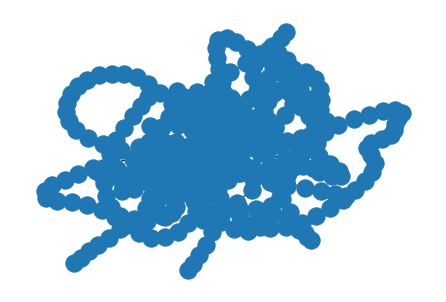

In [17]:
nx.draw(grafo)

In [ ]:
#nx.write_gml(grafo, 'Terminal_Cabral.gml')